In [206]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [231]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 16
K = 15
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10 
noise = -174+10*np.log10(BW) + NF

# Network Parameters
BASE_STATION_POSITION = (0, 0, 20)
NUM_SIMULATIONS = 100
TRANSMIT_POWER_WATTS = 4 #in watts (For other cases, change power from 0.1 to 4)
NUM_SIMULATIONS = 100
dThreshold = GRID_RADIUS/ 2 # Changed from 40 to 20

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = np.sqrt(0.5)
# m = 2 #Changed the shape from 1 to 2
# omega = np.sqrt(0.5)
m = 2 #Changed the shape from 1 to 2
omega = np.sqrt(0.5)

# Path Loss Parameters
BETA1 = 2.8 #path loss exponent (indirect) bs -> irs
BETA2 = 2.2  #path loss exponent (indirect) irs -> user
ALPHA = 3.8 #path loss exponent (direct) bs -> user

# IRS Elements
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRSrow*nIRScol

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

# Generate BS position
xt, yt, zt = BASE_STATION_POSITION
loc_T = np.array([BASE_STATION_POSITION])

In [232]:
grid_radius_array = np.arange(100, 1401, 100)

# Define empty lists
grid_area_list = []
IRS_POSITION_1_list = []
IRS_POSITION_2_list = []
loc_U_list = []
threshold_list = []
dTU_list = []
dTS_1_list = []
dTS_2_list = []
dSU_1_list = []
dSU_2_list = []

# Usage within the loop
for GRID_RADIUS in grid_radius_array:
    
    # Function calculate_values_for_radius returns the following 4 quantities
    grid_area, IRS_POSITION_1, IRS_POSITION_2, loc_U , threshold= calculate_values_for_radius(GRID_RADIUS, K) 

    # Append the values to the respective lists
    grid_area_list.append(grid_area)
    IRS_POSITION_1_list.append(IRS_POSITION_1)
    IRS_POSITION_2_list.append(IRS_POSITION_2)
    loc_U_list.append(loc_U)
    threshold_list.append(threshold)

    xs_1, ys_1, zs_1 = IRS_POSITION_1
    loc_S_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)

    xs_2, ys_2, zs_2 = IRS_POSITION_2
    loc_S_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)

    # #Distance Calulation
    dTU_temp, dSU_1_temp, dTS_1_temp = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU_temp, dSU_2_temp, dTS_2_temp = calculate_distances_3D(loc_U, loc_T, loc_S_2)

    dTU_list.append(dTU_temp.transpose()[0])
    dTS_1_list.append(dTS_1_temp.transpose()[0])
    dTS_2_list.append(dTS_2_temp.transpose()[0])
    dSU_1_list.append(dSU_1_temp.transpose()[0])
    dSU_2_list.append(dSU_2_temp.transpose()[0])


grid_area_list = np.array(grid_area_list) # Shape = (len(grid_radius_array),)
IRS_POSITION_1_list = np.array(IRS_POSITION_1_list) # Shape = (len(grid_radius_array), 3)
IRS_POSITION_2_list = np.array(IRS_POSITION_2_list) # Shape = (len(grid_radius_array), 3)
loc_U_list = np.array(loc_U_list) # Shape = (len(grid_radius_array), K, 3)
threshold_list = np.array(threshold_list)

dTU_list = np.array(dTU_list)
dTU_list = np.vstack(dTU_list)  # Shape = (len(grid_radius_array), K)

dTS_1_list = np.array(dTS_1_list)
dTS_1_list = np.vstack(dTS_1_list)  # Shape = (len(grid_radius_array), Ns)

dTS_2_list = np.array(dTS_2_list)
dTS_2_list = np.vstack(dTS_2_list)  # Shape = (len(grid_radius_array), Ns)

dSU_1_list = np.array(dSU_1_list)
dSU_1_list = np.vstack(dSU_1_list)  # Shape = (len(grid_radius_array), K)

dSU_2_list = np.array(dSU_2_list)
dSU_2_list = np.vstack(dSU_2_list)  # Shape = (len(grid_radius_array), K)



# print(IRS_POSITION_1_list.shape)
# print()
# print(IRS_POSITION_2_list.shape)
# print()
print(dTU_list.shape)
# print()
print(threshold_list)
# print(dSU_2_list.shape)

(14, 16)
[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.]


Generating Channels

In [233]:
h_dk_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,1), dtype= np.complex128)
h_rk1_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,K), dtype= np.complex128)
h_rk1_h_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,Ns), dtype= np.complex128)
G1_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,1), dtype= np.complex128)
h_rk2_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,K), dtype= np.complex128)
h_rk2_h_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),K,Ns), dtype= np.complex128) 
G2_4d = np.zeros((NUM_SIMULATIONS,len(grid_radius_array),Ns,1), dtype= np.complex128)

# Perform simulations
for i in range(NUM_SIMULATIONS):
        
    for j in range(len(grid_radius_array)):
        # Generate the Rayleigh Fading Channel for each user (h_dk)
        # h_dk = np.zeros((K,1))
        h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
        for m in range(K):
            dTU = dTU_list[j]
            dThreshold = threshold_list[j]
            if(dTU[m] > dThreshold*0) or (dTU[m] < dThreshold*0):
                h_dk[m] = 0
        h_dk = np.reshape(h_dk ,(K,1))
        h_dk_4d[i][j] = h_dk
        
        # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
        fading = []
        for user in range(K):
            fading.append(generate_rayleigh_fading_channel(Ns, FADING_STD_MEAN, FADING_STD_DEV)) 
        h_rk1 = fading
        h_rk1 = np.reshape(h_rk1,(Ns,K))
        h_rk1_transpose = np.transpose(h_rk1)
        h_rk1_h = np.conj(h_rk1_transpose)
        h_rk1_4d[i][j] = h_rk1
        h_rk1_h_4d[i][j] = h_rk1_h


        # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
        fading = []
        for user in range(K):
            fading.append(generate_rayleigh_fading_channel(Ns, FADING_STD_MEAN, FADING_STD_DEV)) 
        h_rk2 = fading
        h_rk2 = np.reshape(h_rk2,(Ns,K))
        h_rk2_transpose = np.transpose(h_rk2)
        h_rk2_h = np.conj(h_rk2_transpose)
        h_rk2_4d[i][j] = h_rk2
        h_rk2_h_4d[i][j] = h_rk2_h

        # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
        G1 = generate_rayleigh_fading_channel(Ns, FADING_STD_MEAN, FADING_STD_DEV)
        G1 = np.reshape(G1,(Ns,1))
        G1_4d[i][j] = G1

        # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
        G2 = generate_rayleigh_fading_channel(Ns, FADING_STD_MEAN, FADING_STD_DEV)
        G2 = np.reshape(G2,(Ns,1))
        G2_4d[i][j] = G2

print('Size of hdk4d', np.shape(h_dk_4d))
print('Size of hrk4d', np.shape(h_rk1_4d))
print('Size of hrkh4d', np.shape(h_rk1_h_4d))
print('Size of g4d', np.shape(G1_4d))

Size of hdk4d (100, 14, 16, 1)
Size of hrk4d (100, 14, 100, 16)
Size of hrkh4d (100, 14, 16, 100)
Size of g4d (100, 14, 100, 1)


In [234]:
# h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

#         # BS to IRS
# G1_ns_values = [G1_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
# G2_ns_values = [G2_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

#         # IRS to Users
# h_rk1_ns_values = [h_rk1_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
# h_rk2_ns_values = [h_rk2_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)    
# h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)

Simulations for Ideal Continuos Case, Double IRS

In [235]:
RATE_THRESHOLD = 10
B = None
Pt = np.arange(0,51,10)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))


    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    area_energy_efficiency_1 = []
    area_spectral_efficiency_1 = []
    
    for i in range(len(grid_radius_array)):
    
        grid_area = grid_area_list[i]
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU_list[i]
        # print('dTU',dTU.shape)
    
        # Compute row-wise averages
        dSU_1 = dSU_1_list[i]
        # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # print('dSU1',dSU_1.shape)
        
        # Compute the sum of elements in each row
        dTS_1 = dTS_1_list[i]
        # dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # print('dTS1',dTS_1.shape)
    
        # Compute row-wise averages
        dSU_2 = dSU_2_list[i]
        # dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # print('dSU2',dSU_2.shape)
    
        # Compute the sum of elements in each row
        dTS_2 = dTS_2_list[i]
        # dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)
        # print('dTS2',dTS_2.shape)
    
    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
    #  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
        # Direct Link
        h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)
    
        # BS to IRS
        G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = G2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    
        # IRS to Users
        h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = h_rk2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = h_rk2_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Initialize list to store area_energy_efficiency
        area_energy_efficiency = []
        
        # Initialize area_spectral_efficiency for this case
        area_spectral_efficiency = []
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_values[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    
            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
            theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)
    
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)
    
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+ (results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA2)*(dTS_2**BETA1)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
    
            # Calculate the Area Spectral Efficiency (ASE)
            ASE = arr_sumrate_disc[s]/grid_area
            area_spectral_efficiency.append(ASE)
    
            # Calculate the total power of the system
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3
    
            # Compute the energy efficiency and the Area Energy Efficiency (AEE)
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            AEE = ASE/P # Using the ASE and total power
            area_energy_efficiency.append(ee/1e6) 
    
        # Compute the average area energy efficiency
        area_energy_efficiency_1.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
        
        # Append the average ASE for this T to the list
        area_spectral_efficiency_1.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))


    results_dict_1[T] = area_energy_efficiency_1

print('done')

done


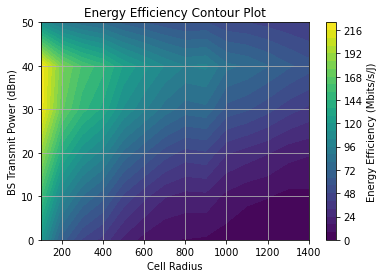

In [236]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate((grid_radius_array)):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_1[transmit_power][i]

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 30  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(g, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Cell Radius')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [211]:
np.savetxt('./CSVDataFiles/Nmesh.csv', N, delimiter=',')
np.savetxt('./CSVDataFiles/Ptmesh.csv', Pt, delimiter=',')
np.savetxt('./CSVDataFiles/EE_Double_Ideal.csv', energy_efficiency_matrix, delimiter=',')

NameError: name 'N' is not defined

In [34]:
# # Plot the graph for each value of T
# for T, average_energy_efficiency_1 in results_dict_1.items():
#     plt.plot(grid_radius_array, average_energy_efficiency_1, label=f'Pt={T} dBm')

# plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
# plt.xlabel('Cell Radius')
# plt.title('Energy Efficiency Vs Cell Radius for Different Transmit Powers')
# plt.legend()
# plt.grid(True)
# plt.show()

Simulations for Practical Discrete Case, Double IRS (B = 3)

In [237]:
RATE_THRESHOLD = 10
B = 3
Pt = np.arange(0,51,10)

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))


    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_2 = {}

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    area_energy_efficiency_2 = []
    area_spectral_efficiency_2 = []
    
    for i in range(len(grid_radius_array)):
    
        grid_area = grid_area_list[i]
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU_list[i]
    
        # Compute row-wise averages
        dSU_1 = dSU_1_list[i]
        # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
    
        # Compute the sum of elements in each row
        dTS_1 = dTS_1_list[i]
        # dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
    
        # Compute row-wise averages
        dSU_2 = dSU_2_list[i]
        # dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
    
        # Compute the sum of elements in each row
        dTS_2 = dTS_2_list[i]
        # dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)
    
    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
    #  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
        # Direct Link
        h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)
    
        # BS to IRS
        G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = G2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    
        # IRS to Users
        h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = h_rk2_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = h_rk2_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Initialize list to store area_energy_efficiency
        area_energy_efficiency = []
        
        # Initialize area_spectral_efficiency for this case
        area_spectral_efficiency = []
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_values[s]
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    
            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
            theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
    
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)
    
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+ (results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_2[:,m]**BETA2)*(dTS_2**BETA1)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
    
            # Calculate the Area Spectral Efficiency (ASE)
            ASE = arr_sumrate_disc[s]/grid_area
            area_spectral_efficiency.append(ASE)
    
            # Calculate the total power of the system
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3
    
            # Compute the energy efficiency and the Area Energy Efficiency (AEE)
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            AEE = ASE/P # Using the ASE and total power
            area_energy_efficiency.append(ee/1e6) 
    
        # Compute the average area energy efficiency
        area_energy_efficiency_2.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
        
        # Append the average ASE for this T to the list
        area_spectral_efficiency_2.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))


    results_dict_2[T] = area_energy_efficiency_2

print('done')

done


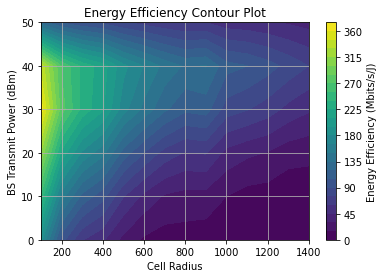

In [238]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate((grid_radius_array)):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_2[transmit_power][i]

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 30  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(g, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Cell Radius')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')

plt.grid(True)
plt.show()

In [16]:
np.savetxt('./CSVDataFiles/EE_Double_practB3.csv', energy_efficiency_matrix, delimiter=',')

In [39]:
# # Plot the graph for each value of T
# for T, average_energy_efficiency_2 in results_dict_2.items():
#     plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

# plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
# plt.xlabel('Number of IRS elements')
# plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
# plt.legend()
# plt.grid(True)
# plt.show()

Simulations for Ideal Continuos Case, Single IRS

In [239]:
RATE_THRESHOLD = 10
B = None
Pt = np.arange(0,51,10)

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))


    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_3 = {}

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    area_energy_efficiency_3 = []
    area_spectral_efficiency_3 = []
    
    for i in range(len(grid_radius_array)):
    
        grid_area = grid_area_list[i]
        
        # Generate IRS position_1
        # IRS_position_1 = IRS_POSITION_1_list[i]
        # xs_1, ys_1, zs_1 = IRS_POSITION_1
    
        # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        # loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
    
        loc_U = loc_U_list[i]
        
        # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU_list[i]
        # dTU = dTU.reshape(Nt,K)
    
        # Compute row-wise averages
        dSU_1 = dSU_1_list[i]
        # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
    
        # Compute the sum of elements in each row
        dTS_1 = dTS_1_list[i]
        # dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
    
    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
    #  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
        # Direct Link
        h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)
    
        # BS to IRS
        G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    
        # IRS to Users
        h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Initialize list to store area_energy_efficiency
        area_energy_efficiency = []
        
        # Initialize area_spectral_efficiency for this case
        area_spectral_efficiency = []
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_values[s]
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None )
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
    
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
    
            # Calculate the Area Spectral Efficiency (ASE)
            ASE = arr_sumrate_disc[s]/grid_area
            area_spectral_efficiency.append(ASE)
    
            # Calculate the total power of the system
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_2 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_2 + power_3
    
            # Compute the energy efficiency and the Area Energy Efficiency (AEE)
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            AEE = ASE/P # Using the ASE and total power
            area_energy_efficiency.append(ee/1e6) 
    
        # Compute the average area energy efficiency
        area_energy_efficiency_3.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
        
        # Append the average ASE for this T to the list
        area_spectral_efficiency_3.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))


    results_dict_3[T] = area_energy_efficiency_3

print('done')

done


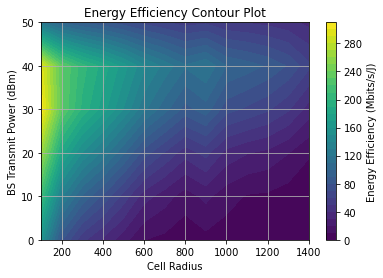

In [240]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate((grid_radius_array)):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_3[transmit_power][i]

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 30  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(g, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Cell Radius')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')
plt.grid(True)
plt.show()

In [22]:
np.savetxt('./CSVDataFiles/EE_Single_Ideal.csv', energy_efficiency_matrix, delimiter=',')

In [42]:
# # Plot the graph for each value of T
# for T, average_energy_efficiency_1 in results_dict_2.items():
#     plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

# plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
# plt.xlabel('Number of IRS elements')
# plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
# plt.legend()
# plt.grid(True)
# plt.show()

Simulations for Practical Discrete Case, Single IRS

In [241]:
RATE_THRESHOLD = 10
B = 3
Pt = np.arange(0,51,10)

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))


    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_4 = {}

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

for T in Pt:
    TRANSMIT_POWER_WATTS = dBm2pow(T)
    area_energy_efficiency_4 = []
    area_spectral_efficiency_4 = []
    
    for i in range(len(grid_radius_array)):
    
        grid_area = grid_area_list[i]
        
        # Generate IRS position_1
        # IRS_position_1 = IRS_POSITION_1_list[i]
        # xs_1, ys_1, zs_1 = IRS_POSITION_1
    
        # irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        # loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
    
        loc_U = loc_U_list[i]
        
        # dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        # dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU_list[i]
        # dTU = dTU.reshape(Nt,K)
    
        # Compute row-wise averages
        dSU_1 = dSU_1_list[i]
        # dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
    
        # Compute the sum of elements in each row
        dTS_1 = dTS_1_list[i]
        # dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
    
    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
    #  ---------------------------------------------------------Extracting Channel Values-----------------------------------------------------------------------------------
        # Direct Link
        h_dk_values = h_dk_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, 1)
    
        # BS to IRS
        G1_ns_values = G1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    
        # IRS to Users
        h_rk1_ns_values = h_rk1_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = h_rk1_h_4d[:,i,:,:]  # Shape: (NUM_SIMULATIONS, K, Ns)
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Initialize list to store area_energy_efficiency
        area_energy_efficiency = []
        
        # Initialize area_spectral_efficiency for this case
        area_spectral_efficiency = []
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_values[s]
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
    
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* (((h_dk[m])/(np.sqrt((dTU[m])**ALPHA)))+((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
    
            # Calculate the Area Spectral Efficiency (ASE)
            ASE = arr_sumrate_disc[s]/grid_area
            area_spectral_efficiency.append(ASE)
    
            # Calculate the total power of the system
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_2 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_2 + power_3
    
            # Compute the energy efficiency and the Area Energy Efficiency (AEE)
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            AEE = ASE/P # Using the ASE and total power
            area_energy_efficiency.append(ee/1e6) 
    
        # Compute the average area energy efficiency
        area_energy_efficiency_4.append((np.sum(area_energy_efficiency)/NUM_SIMULATIONS))
        
        # Append the average ASE for this T to the list
        area_spectral_efficiency_4.append((np.sum(area_spectral_efficiency)/NUM_SIMULATIONS))


    results_dict_4[T] = area_energy_efficiency_4

print('done')

done


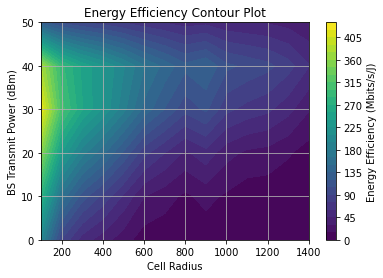

In [242]:
# Extract the values from the dictionary and create a 2D array
energy_efficiency_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate((grid_radius_array)):
    for j, transmit_power in enumerate(Pt):
        energy_efficiency_matrix[i, j] = results_dict_4[transmit_power][i]

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 30  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(g, Pt, energy_efficiency_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='Energy Efficiency (Mbits/s/J)')

plt.xlabel('Cell Radius')
plt.ylabel('BS Transmit Power (dBm)')
plt.title('Energy Efficiency Contour Plot')
plt.grid(True)
plt.show()

In [26]:
np.savetxt('./CSVDataFiles/EE_Single_practB3.csv', energy_efficiency_matrix, delimiter=',')


In [70]:
# # Plot the graph for each value of T
# for T, average_energy_efficiency_1 in results_dict_2.items():
#     plt.plot(N_values, average_energy_efficiency_1, label=f'Pt={T} dBm')

# plt.ylabel('Average Energy Efficiency (Mbits/s/J)')
# plt.xlabel('Number of IRS elements')
# plt.title('Energy Efficiency Vs IRS Elements for Different Transmit Powers')
# plt.legend()
# plt.grid(True)
# plt.show()

{0: array([-11.71643651,   7.23932427,   8.19687491,  10.54928679,
         3.66143242,   5.43796652,   2.32027343,   5.89551177,
         1.32350594,   0.67088201,   0.58289503,   0.47254176,
         0.28023831,   1.18128853]), 10: array([-26.48863943,  -3.25471173,   2.92393622,   9.43894315,
         3.06687337,  10.25630165,   6.6717337 ,  12.78103846,
         4.44429255,   2.51429989,   2.7516874 ,   2.22943202,
         1.52200417,   4.66963497]), 20: array([-41.37117382, -17.29675397,  -9.02016997,   0.61921064,
        -3.6414747 ,   8.98785064,   8.82737063,  16.87339376,
         6.69158881,   4.68090407,   6.31861295,   4.7740528 ,
         3.96210946,  10.75630479]), 30: array([-52.43648254, -29.55567125, -21.38603315, -11.00579216,
       -14.34608502,   0.26985674,   3.36559884,  13.29784589,
         3.52670095,   3.72000428,   6.28815316,   4.03472711,
         5.09403825,  15.75011349]), 40: array([-34.80771623, -20.80012353, -16.1419581 ,  -8.86951365,
       -12.72

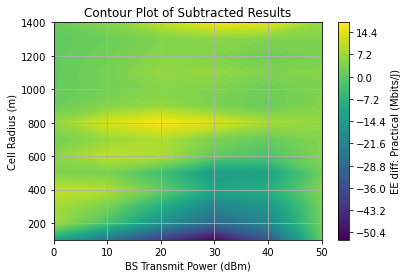

In [243]:
# Provide the values for the y-axis and x-axis
grid_radius_array = np.arange(100, 1401, 100)
Pt = np.arange(0, 51, 10)

# Subtract corresponding elements from dictionaries results_dict_4 and results_dict_2
subtracted_results = {}

for T in results_dict_2:
    if T in results_dict_4:
        subtracted_results[T] = np.array(results_dict_2[T]) - np.array(results_dict_4[T])
    else:
        print(f"Key {T} not found in results_dict_2")

# Display the subtracted results
print(subtracted_results)

# Extract the values from the dictionary and create a 2D array
subtracted_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate(grid_radius_array):
    for j, transmit_power in enumerate(Pt):
        if transmit_power in subtracted_results:
            subtracted_matrix[i, j] = subtracted_results[transmit_power][i]
        else:
            subtracted_matrix[i, j] = np.nan

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 100  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(Pt,g, subtracted_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='EE diff: Practical (Mbits/J)')

plt.ylabel('Cell Radius (m)')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Contour Plot of Subtracted Results')
plt.grid(True)
plt.show()

{0: array([-3.91771651e+01, -1.31659597e+01, -5.84688734e+00, -1.35482406e+00,
       -2.13324523e+00,  2.71500932e+00,  7.87651024e-01,  4.58715138e+00,
        1.39000525e-01, -1.53395482e-02,  3.82389850e-01,  2.53006893e-01,
        2.34291222e-01,  1.36752127e+00]), 10: array([-5.64972426e+01, -2.90237841e+01, -1.88807759e+01, -1.12868955e+01,
       -9.83862343e+00, -1.66404573e-01,  1.64203450e-02,  5.97951029e+00,
       -9.97031690e-01, -4.56997111e-01,  6.78613577e-01,  2.13441755e-01,
        4.95537287e-01,  3.81941445e+00]), 20: array([-73.64970425, -45.98311606, -35.05762935, -26.2454659 ,
       -23.49517955, -10.63660015,  -6.91485061,   1.09818572,
        -6.72322979,  -3.822189  ,  -2.17351916,  -2.71880427,
        -1.33270477,   5.58521586]), 30: array([-87.48484467, -60.74308146, -50.07240666, -41.28371253,
       -38.36547846, -24.84522924, -19.46706732, -10.26787745,
       -17.89494726, -12.90763736, -11.08324803, -10.99212297,
        -8.18713677,   2.66509645

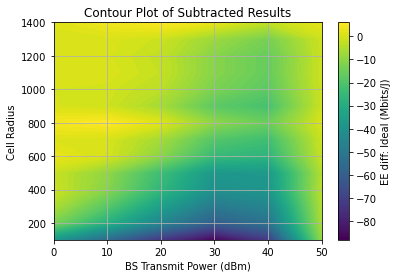

In [244]:
# Provide the values for the y-axis and x-axis
grid_radius_array = np.arange(100, 1401, 100)
Pt = np.arange(0, 51, 10)

# Subtract corresponding elements from dictionaries results_dict_4 and results_dict_2
subtracted_results = {}

for T in results_dict_1:
    if T in results_dict_3:
        subtracted_results[T] = np.array(results_dict_1[T]) - np.array(results_dict_3[T])
    else:
        print(f"Key {T} not found in results_dict_2")

# Display the subtracted results
print(subtracted_results)

# Extract the values from the dictionary and create a 2D array
subtracted_matrix = np.zeros((len(grid_radius_array), len(Pt)))

for i, g_value in enumerate(grid_radius_array):
    for j, transmit_power in enumerate(Pt):
        if transmit_power in subtracted_results:
            subtracted_matrix[i, j] = subtracted_results[transmit_power][i]
        else:
            subtracted_matrix[i, j] = np.nan

# Create a meshgrid for N and T values
g, Pt = np.meshgrid(grid_radius_array, Pt)

# Increase the number of contour levels for smoother appearance
num_levels = 100  # Adjust this number as needed

# Create the contour plot with smooth contours
contour = plt.contourf(Pt,g, subtracted_matrix.T, num_levels, cmap='viridis')
plt.colorbar(contour, label='EE diff: Ideal (Mbits/J)')

plt.ylabel('Cell Radius')
plt.xlabel('BS Transmit Power (dBm)')
plt.title('Contour Plot of Subtracted Results')
plt.grid(True)
plt.show()